In [15]:
pip install fastf1

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fastf1.plotting
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

In [2]:
# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl(misc_mpl_mods=False)


# load a session and its telemetry data
session = fastf1.get_session(2024, 'Australian Grand Prix', 'Race')
session.load()
# In this way i Can exclude the box laps
laps = session.laps.pick_wo_box()

# Pick just the accurate laps
laps = laps[laps['IsAccurate']==True]





req         WARNING 	DEFAULT CACHE ENABLED! (574.68 MB) /Users/PietroPaolo/Library/Caches/fastf1


core           INFO 	Loading data for Australian Grand Prix - Race [v3.3.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


In [3]:
drivers =laps['Driver'].unique()
compounds = laps['Compound'].unique()


In [4]:
def timedelta_to_seconds(td: pd.Timedelta) -> float:
    """
    Convert a pandas Timedelta to a float representing the total seconds.
    
    Parameters:
    - td: pd.Timedelta
    
    Returns:
    - float: total seconds
    """
    return td.total_seconds()

In [5]:
# Transform the laps in total seconds
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()



# order the team from the fastest (lowest median lap time) to slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)

# make a color palette associating team names to hex codes
# Define the specific color for 'Kick Sauber'
specific_color = '#90EE90'  # Light green

# Make a color palette associating team names to hex codes
team_palette = {team: (specific_color if team == 'Kick Sauber' else fastf1.plotting.team_color(team)) for team in team_order}



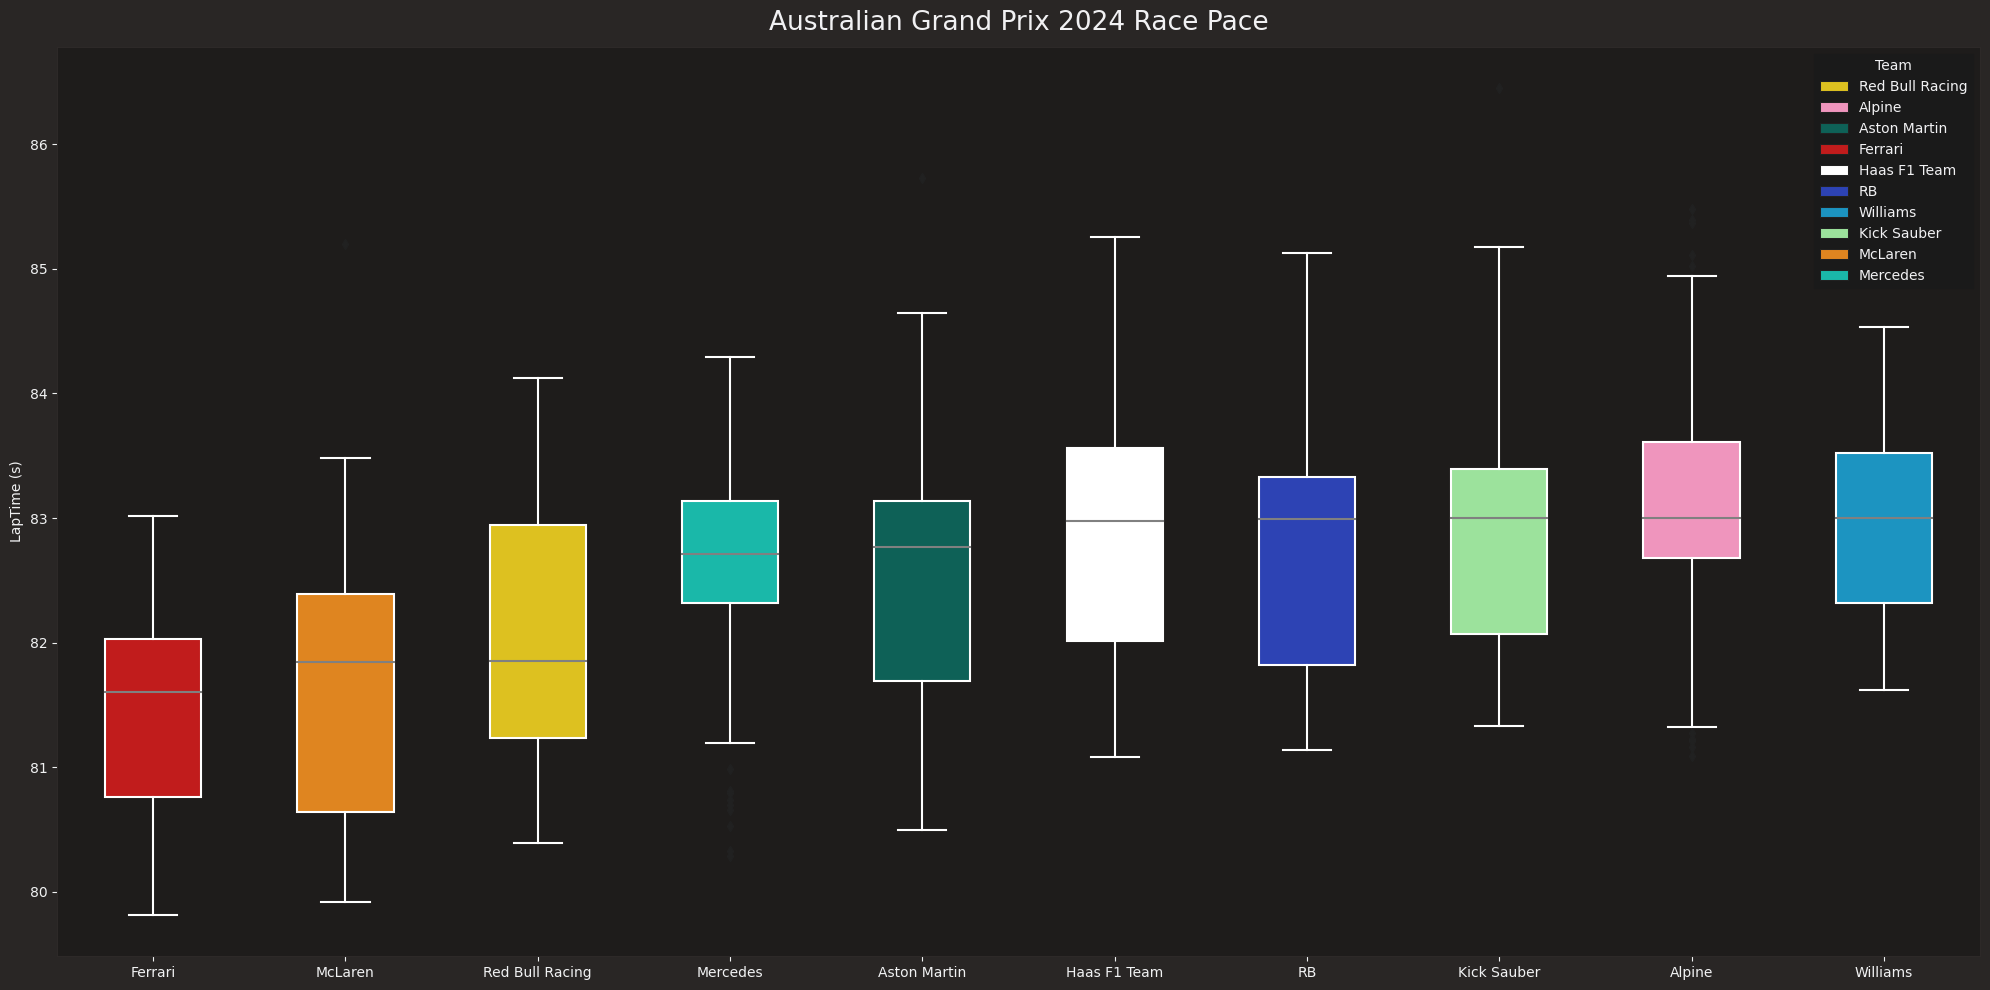

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))  # Increased figure size to accommodate wider boxes
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    width=0.5,  # Increased width value
    dodge=False  # Ensure that boxes are centered under each team name
)

plt.title(f"{session.event['EventName']} {session.event.year} Race Pace")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()





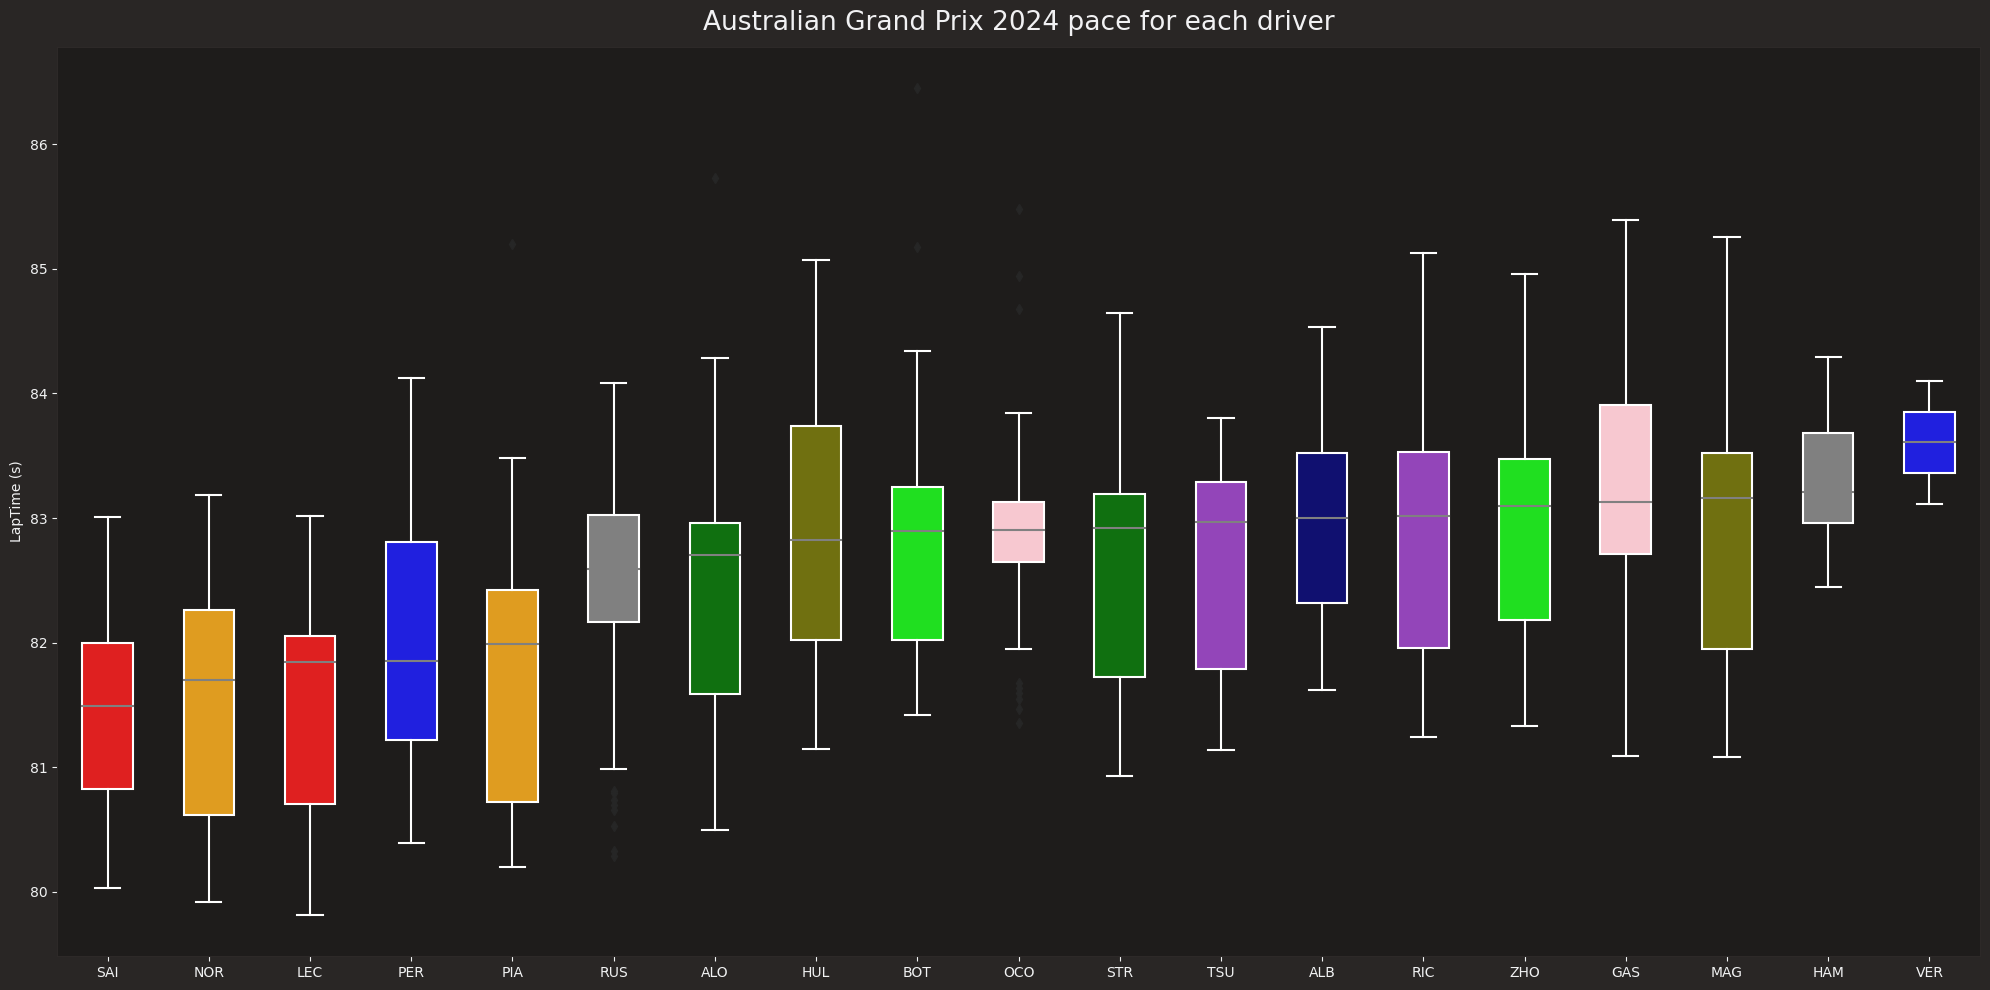

In [7]:
colors = {
    "SAI": "red", "LEC": "red", "NOR": "orange", "PIA": "orange", "PER": "blue",
    "ALO": "green", "RUS": "grey", "STR": "green", "TSU": "#9932CC", "BOT": "lime",
    "OCO": "pink", "HUL": "olive", "MAG": "olive", "RIC": "#9932CC", "ALB": "navy",
    "ZHO": "lime", "GAS": "pink", "HAM": "grey", "VER": "blue", 'SAR':"navy", 'DEV': "#9932CC", 'BEA': "red"
}

median_lap_times = transformed_laps.groupby('Driver')['LapTime (s)'].median()

# Sort the drivers based on the median lap times
sorted_drivers = median_lap_times.sort_values().index

fig, ax = plt.subplots(figsize=(20, 10))  # Increased figure size to accommodate wider boxes
sns.boxplot(
    data=transformed_laps,
    x="Driver",
    y="LapTime (s)",
    palette=colors,
    order=sorted_drivers,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    width=0.5,  # Increased width value
    dodge=False  # Ensure that boxes are centered under each team name
)

plt.title(f"{session.event['EventName']} {session.event.year} pace for each driver")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()



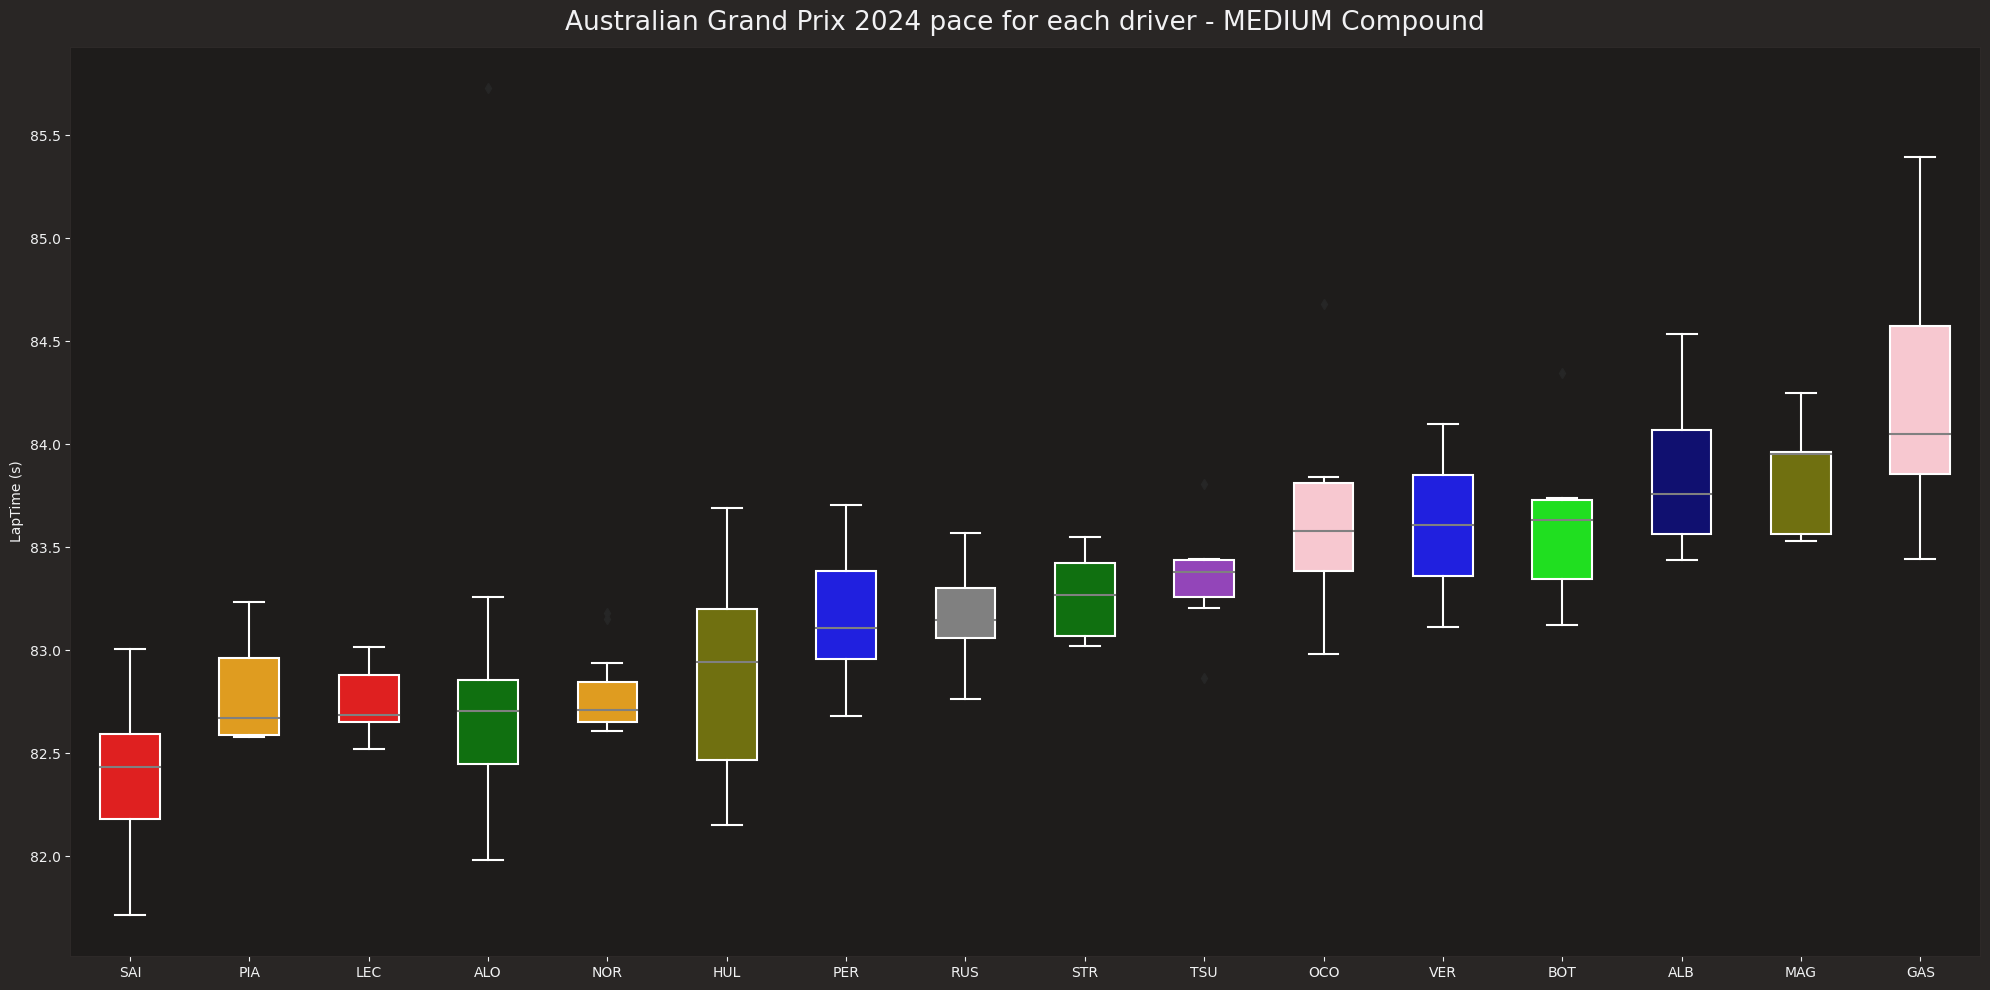

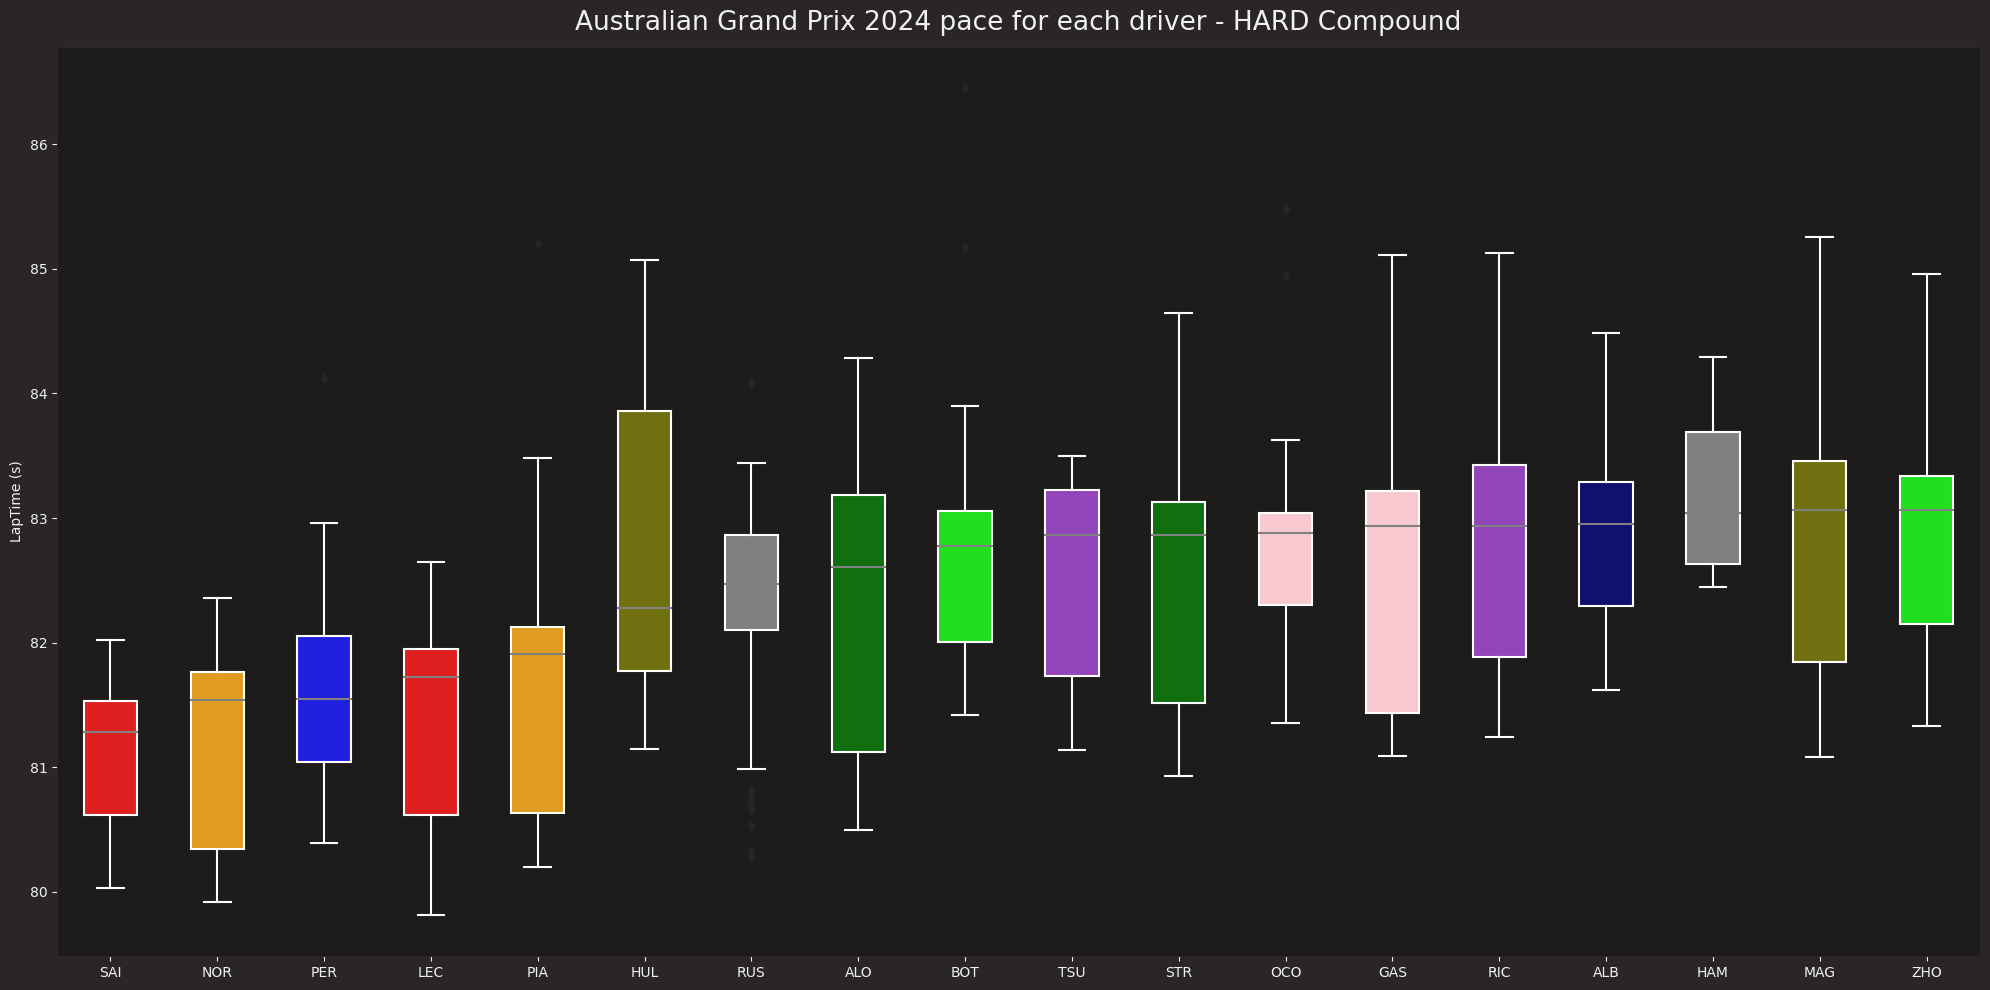

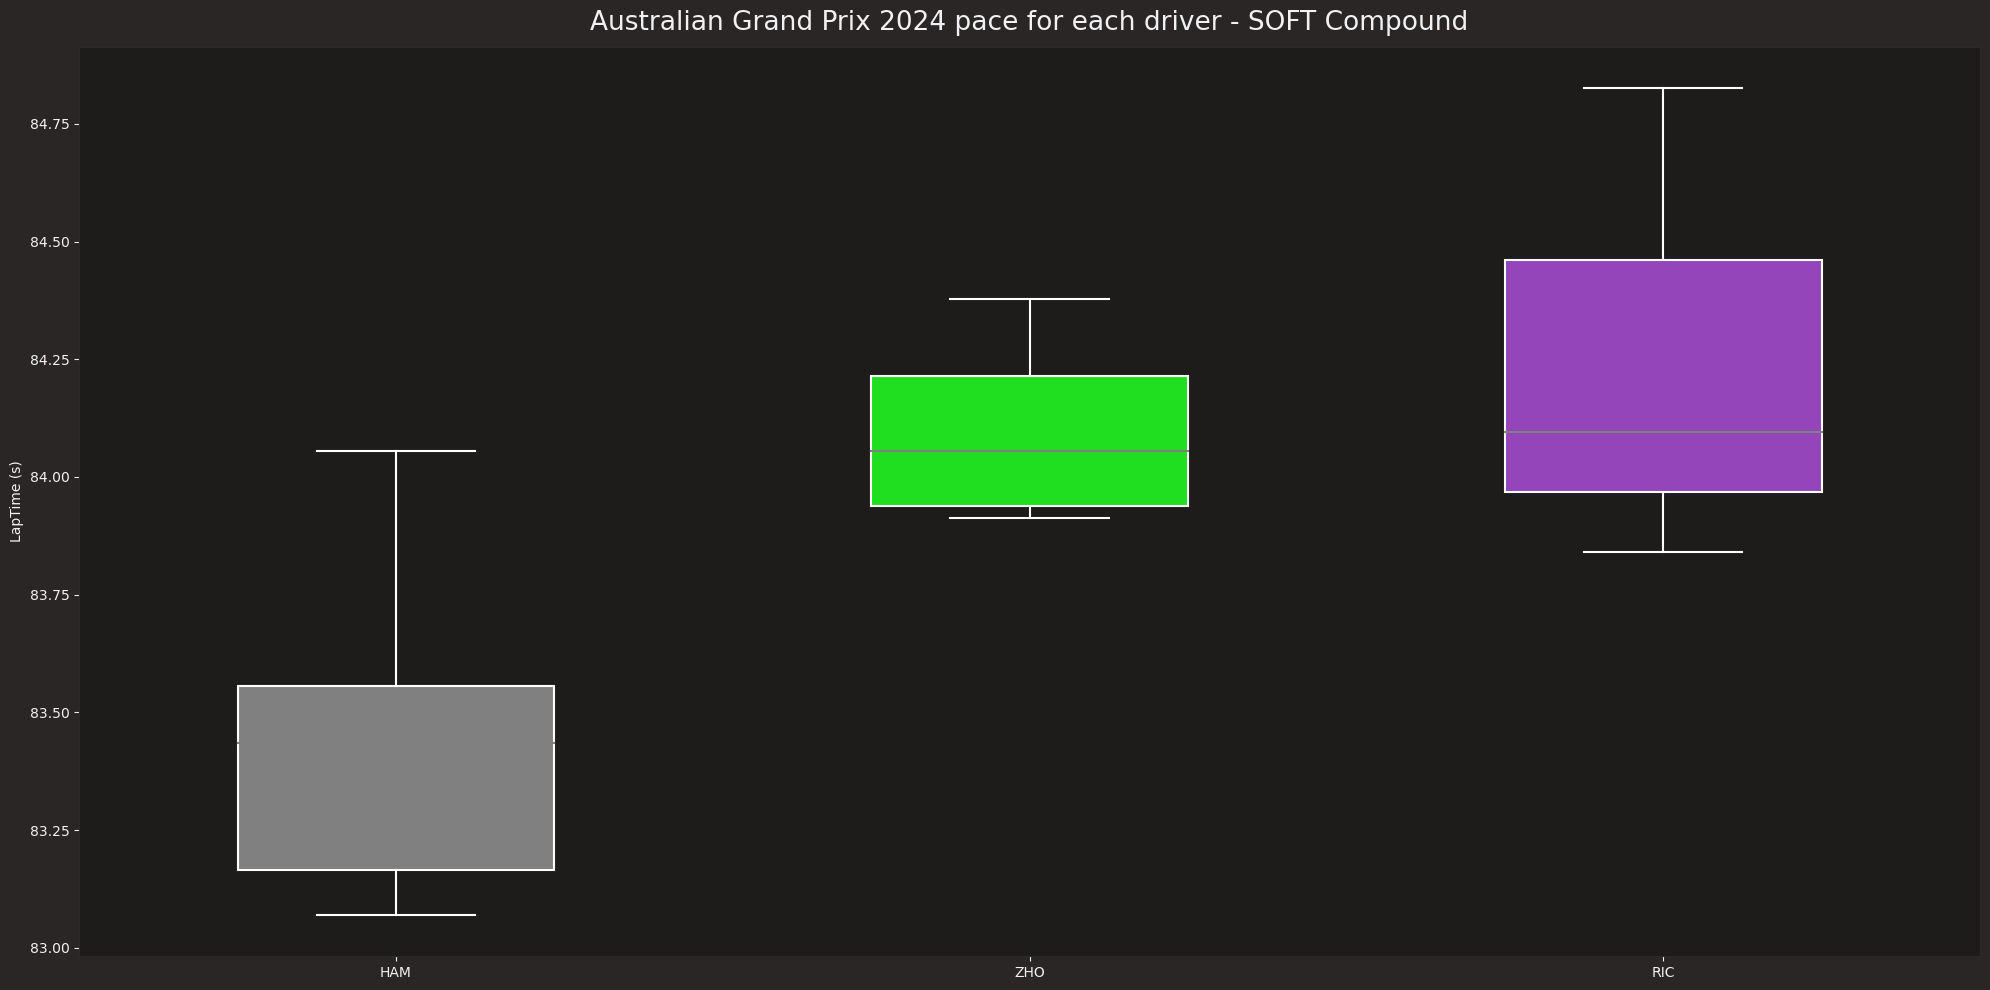

In [8]:
# Define the function to generate the plot for a given compound
def plot_lap_times_for_compound(compound, transformed_laps, colors):
    transformed_laps_with_compound = transformed_laps[transformed_laps['Compound'] == compound]
    median_lap_times_with_compound = transformed_laps_with_compound.groupby('Driver')['LapTime (s)'].median()
    sorted_drivers = median_lap_times_with_compound.sort_values().index

    fig, ax = plt.subplots(figsize=(20, 10))  # Increased figure size to accommodate wider boxes
    sns.boxplot(
        data=transformed_laps_with_compound,
        x="Driver",
        y="LapTime (s)",
        palette=colors,
        order=sorted_drivers,
        whiskerprops=dict(color="white"),
        boxprops=dict(edgecolor="white"),
        medianprops=dict(color="grey"),
        capprops=dict(color="white"),
        width=0.5,  # Increased width value
        dodge=False  # Ensure that boxes are centered under each team name
    )

    plt.title(f"{session.event['EventName']} {session.event.year} pace for each driver - {compound} Compound")
    plt.grid(visible=False)
    ax.set(xlabel=None)
    plt.tight_layout()
    plt.show()

# Generate plots for each compound
for compound in compounds:
    plot_lap_times_for_compound(compound, transformed_laps, colors)

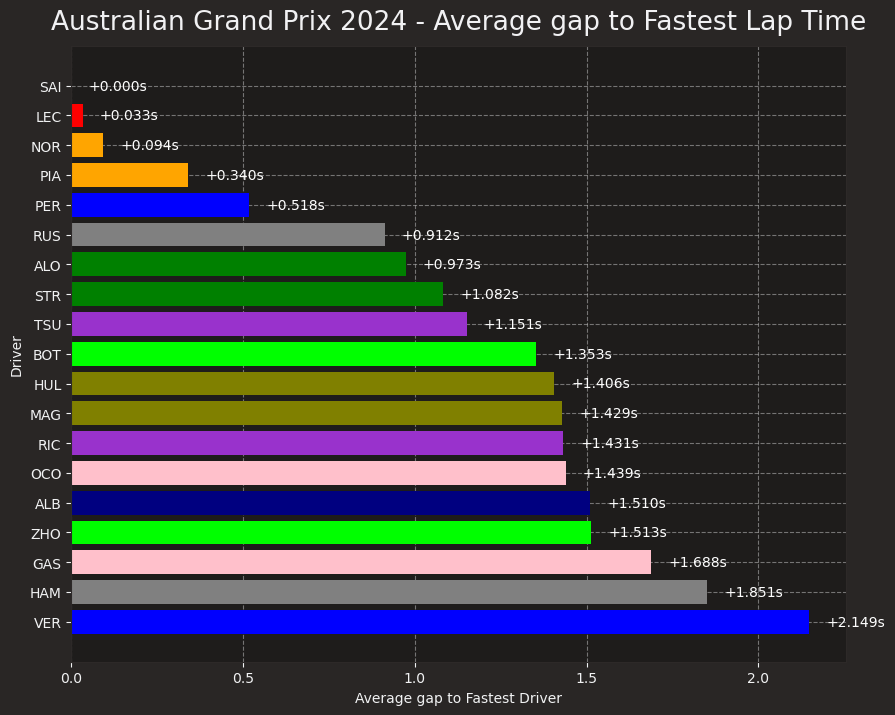

In [9]:
mean_lap_times = transformed_laps.groupby('Driver')['LapTime (s)'].mean()

# Find the fastest lap time
fastest_lap_time = mean_lap_times.min()

# Compute the gap from the fastest lap time for each driver
gap_from_fastest = mean_lap_times - fastest_lap_time

# Sort the gap_from_fastest for better visualization (fastest to slowest)
gap_from_fastest = gap_from_fastest.sort_values(ascending=True)


# Plot the data
plt.figure(figsize=(10, 8))
bars = plt.barh(gap_from_fastest.index, gap_from_fastest.values, color=[colors[driver] for driver in gap_from_fastest.index])
plt.xlabel("Average gap to Fastest Driver")
plt.ylabel("Driver")
plt.title(f"{session.event['EventName']} {session.event.year} - Average gap to Fastest Lap Time")

# Add mean lap times as text labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'+{width:.3f}s', 
             va='center', ha='left', color='white', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # To display the fastest on top
plt.show()

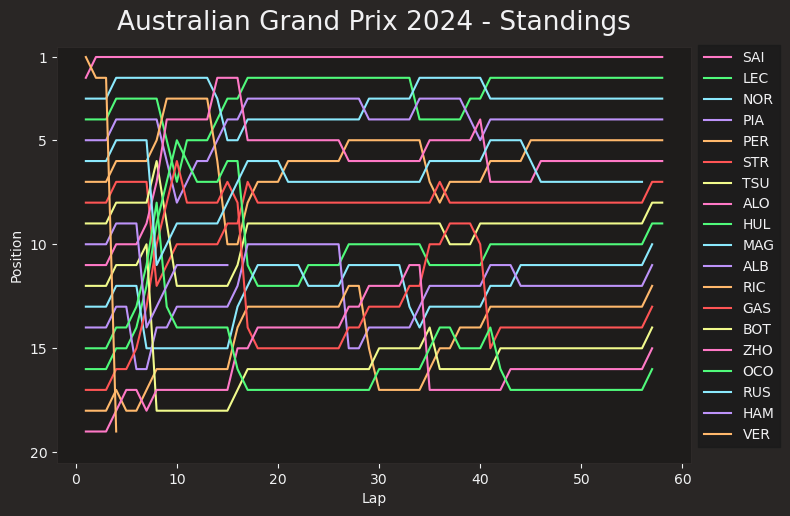

In [10]:
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

fig, ax = plt.subplots(figsize=(8.0, 4.9))

for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    color = colors
    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb)
    
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.title(f"{session.event['EventName']} {session.event.year} - Standings")
plt.show()

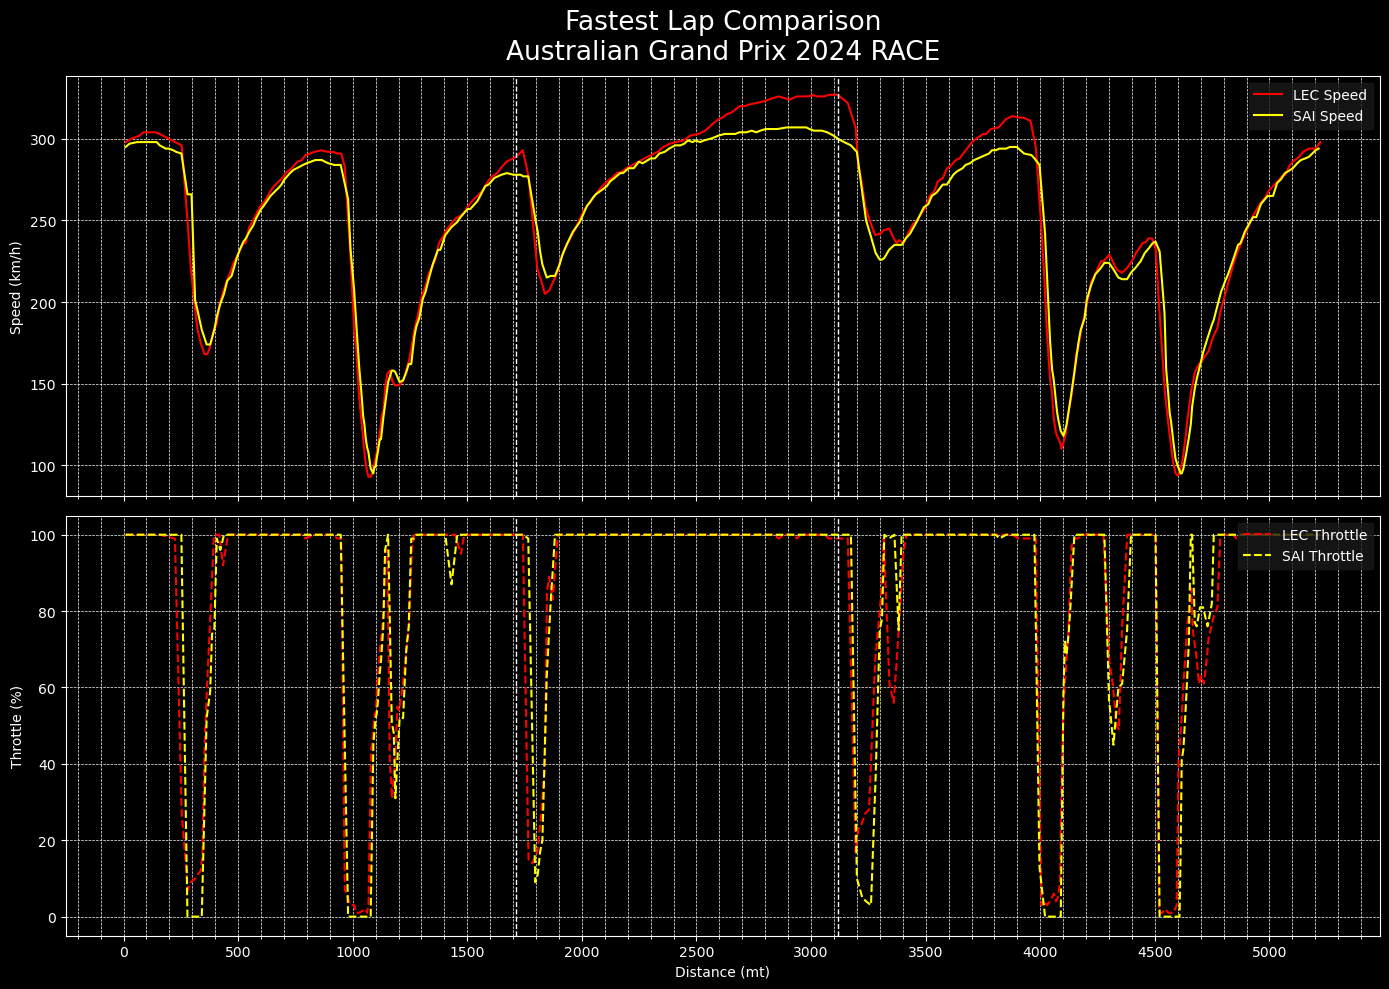

In [13]:
# Extract fastest laps for LEC and SAI
LEC_FASTEST_LAP = transformed_laps.pick_driver('LEC').pick_fastest()
SAI_FASTEST_LAP = transformed_laps.pick_driver('SAI').pick_fastest()

# Get telemetry data and add distance
LEC_tel = LEC_FASTEST_LAP.get_car_data().add_distance()
SAI_tel = SAI_FASTEST_LAP.get_car_data().add_distance()

# Length of the track
length_circuit = LEC_tel['Distance'].max()

# Get sector times for the fastest lap
LEC_sector_times = [
    timedelta_to_seconds(LEC_FASTEST_LAP['Sector1Time']),
    timedelta_to_seconds(LEC_FASTEST_LAP['Sector2Time']),
    timedelta_to_seconds(LEC_FASTEST_LAP['Sector3Time'])
]

# Calculate total lap time
total_lap_time = sum(LEC_sector_times)

# Calculate sector end distances
sector1_end_distance = LEC_tel[LEC_tel['Time'] <= LEC_FASTEST_LAP['Sector1Time']]['Distance'].max()
sector2_end_distance = LEC_tel[LEC_tel['Time'] <= (LEC_FASTEST_LAP['Sector1Time'] + LEC_FASTEST_LAP['Sector2Time'])]['Distance'].max()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Apply a dark background
plt.style.use('dark_background')

# Plot Speed on the first subplot
ax1.plot(LEC_tel['Distance'], LEC_tel['Speed'], color='red', label='LEC Speed')
ax1.plot(SAI_tel['Distance'], SAI_tel['Speed'], color='yellow', label='SAI Speed')
ax1.set_ylabel('Speed (km/h)', color='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', colors='white')
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper right')
ax1.set_title(f"Fastest Lap Comparison\n{session.event['EventName']} {session.event.year} RACE", color='white')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))

# Plot Throttle on the second subplot
ax2.plot(LEC_tel['Distance'], LEC_tel['Throttle'], color='red', linestyle='--', label='LEC Throttle')
ax2.plot(SAI_tel['Distance'], SAI_tel['Throttle'], color='yellow', linestyle='--', label='SAI Throttle')
ax2.set_xlabel('Distance (mt)', color='white')
ax2.set_ylabel('Throttle (%)', color='white')
ax2.tick_params(axis='y', colors='white')
ax2.tick_params(axis='x', colors='white')
ax2.grid(which='both', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper right')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(100))

# Add custom vertical dashed lines for sectors to both subplots
for ax in [ax1, ax2]:
    ax.axvline(x=sector1_end_distance, color='white', linestyle='--', linewidth=1, label='End of Sector 1')
    ax.axvline(x=sector2_end_distance, color='white', linestyle='--', linewidth=1, label='End of Sector 2')

# Adjust layout
plt.tight_layout()
plt.show()


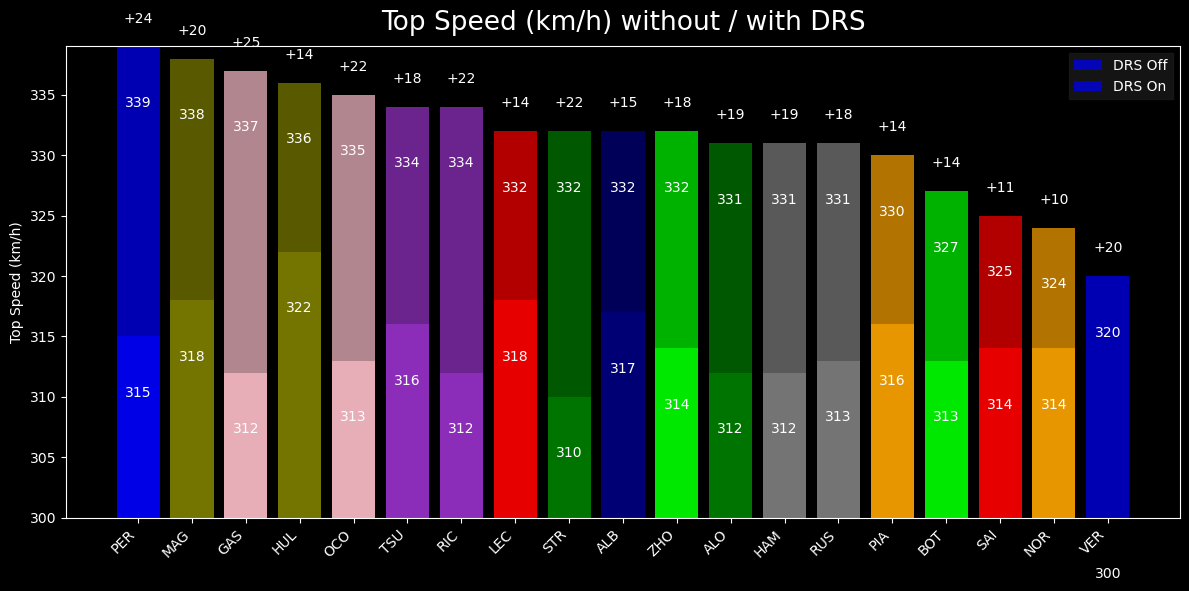

In [12]:
speed_with_drs = {}
speed_without_drs = {}


for pilot in drivers:
    max_speed = transformed_laps.pick_driver(pilot).get_car_data()['Speed'].max()
    speed_with_drs[pilot] = max_speed

for pilot in drivers:
    car_data = transformed_laps.pick_driver(pilot).get_car_data()
    car_data_0_DRS = car_data[car_data['DRS']==0]
    speed_without_drs[pilot]= car_data_0_DRS['Speed'].max()

# Sort the drivers by speed_with_drs in descending order
sorted_drivers = sorted(speed_with_drs, key=speed_with_drs.get, reverse=True)

drivers = list(sorted_drivers)
y_pos = np.arange(len(drivers))

drs_on = [speed_with_drs[driver] for driver in drivers]
drs_off = [speed_without_drs[driver] for driver in drivers]
bar_colors = [colors[driver] for driver in drivers]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(y_pos, drs_off, align='center', alpha=0.7, color=bar_colors,label='DRS Off')
bars2 = ax.bar(y_pos, drs_on, align='center', alpha=0.7, color=bar_colors, label='DRS On')

ax.set_ylabel('Top Speed (km/h)')
ax.set_title('Top Speed (km/h) without / with DRS')
ax.set_xticks(y_pos)
ax.set_xticklabels(drivers, rotation=45, ha="right")

# Setting y-axis limits
ax.set_ylim([300, max(drs_on)])

# Adding text labels
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 - 5, '%d' % int(height1), ha='center', color='white')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 - 5, '%d' % int(height2), ha='center', color='white')
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 2, '+%d' % (height2 - height1), ha='center', color='white')

ax.legend()

plt.tight_layout()
plt.show()

    
